# Building a GAN

---



In [1]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [2]:
device = "cuda" # Transfer Images to the GPU
batch_size = 128 # Trainloader, Training Loop
noise_dim = 64 # Generator Model

# Optimizer Parameters
lr = 0.002
beta_1 = 0.5
beta_2 = 0.99

#Training Variables
epochs = 20

# Loading MNIST Dataset

In [3]:
from torchvision import datasets, transforms as T

In [4]:
train_augs = T.Compose([
    T.RandomRotation((-20, 20)),
    T.ToTensor(), # (h, w, c) -> (c, h, w)
])

In [5]:
trainset = datasets.MNIST('MNIST/', download = True, train = True, transform = train_augs)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 458kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.49MB/s]


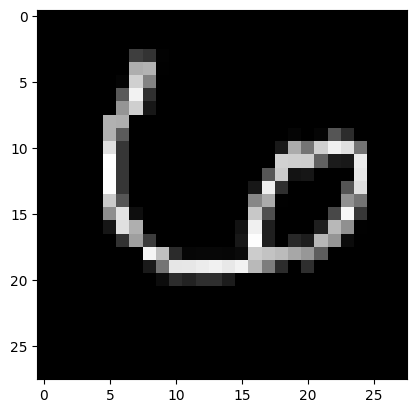

In [10]:
image, label = trainset[770]

plt.imshow(image.squeeze(), cmap = 'gray')

In [9]:
print("Total Images present in trainset:", len(trainset))

Total Images present in trainset: 60000


# Loading Dataset Into Batches

In [11]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [12]:
trainloader = DataLoader(trainset, batch_size, shuffle = True)

In [14]:
print("Total number of batches in Trainloader:", len(trainloader))

Total number of batches in Trainloader: 469


In [16]:
dataiter = iter(trainloader)

images, _ = next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [17]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

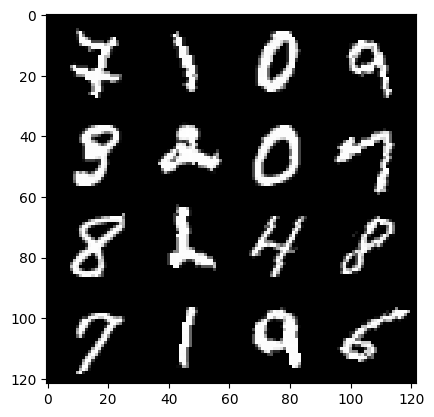

In [18]:
show_tensor_images(images)

# Creating Discriminator Network

In [19]:
!pip install torchsummary

In [20]:
from torch import nn
from torchsummary import summary

In [ ]:
'''
Structure of the Discrimator Network Below:

Network : Discriminator (Binary Classifier)

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [24]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [27]:
class Discrimator(nn.Module):

  def __init__(self):
    super(Discrimator, self).__init__()

    self.block_1 = get_disc_block(1, 16, (3,3), 2)
    self.block_2 = get_disc_block(16, 32, (5,5), 2)
    self.block_3 = get_disc_block(32, 64, (5,5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features=64, out_features=1)

  def forward(self, images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

In [28]:
D = Discrimator()
D.to(device)

summary(D, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Creating Generator Network

In [ ]:
'''
Structure of the Generator Network below:

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [30]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )

  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [33]:
class Generator(nn.Module):

  def __init__(self, noise_dim):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim

    self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block(256, 128, (4,4), 1)
    self.block_3 = get_gen_block(128, 64, (3,3), 2)

    self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block = True)

  def forward(self, rand_noise_vec):

    # (bs, noise_dim) -> (bs, noise_dim, 1, 1)
    rand_noise_vec_shaped = rand_noise_vec.view(-1, self.noise_dim, 1, 1)
    x1 = self.block_1(rand_noise_vec_shaped)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4

In [34]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size = (1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [35]:
# Replacing Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [37]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Creating Loss Function and Load Optimizer

In [42]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [43]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1, beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :  1
Discriminator Loss :  0.6535742248553457
Generator Loss :  0.7895589526782412


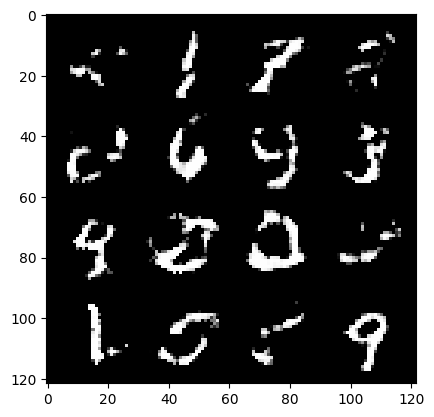

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :  2
Discriminator Loss :  0.6065812080399569
Generator Loss :  0.9347588494896635


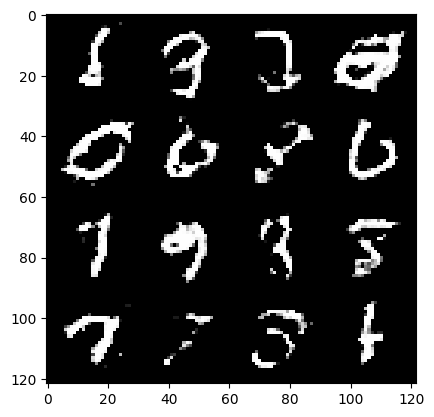

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :  3
Discriminator Loss :  0.5843631922563256
Generator Loss :  1.018163180808777


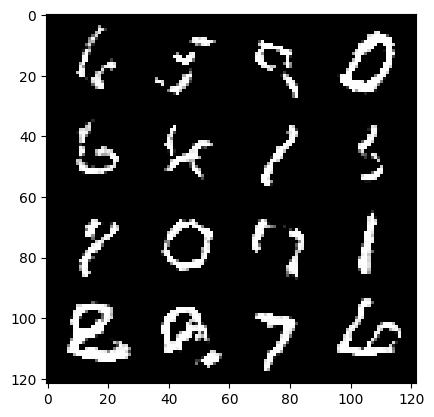

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :  4
Discriminator Loss :  0.5756863819510698
Generator Loss :  1.0737626065831702


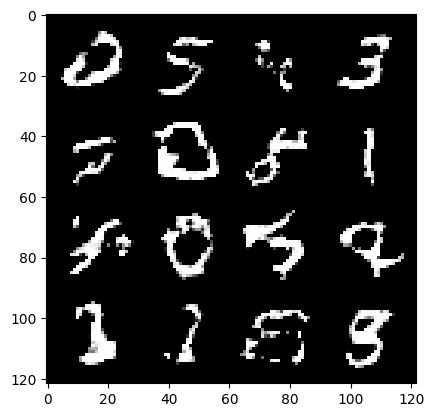

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :  5
Discriminator Loss :  0.5793170192475512
Generator Loss :  1.0752807544238532


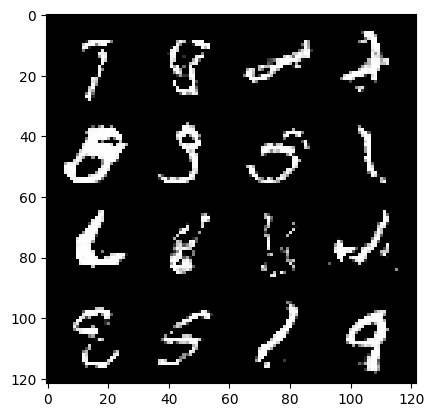

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :  6
Discriminator Loss :  0.5883947716338802
Generator Loss :  1.0670585476005001


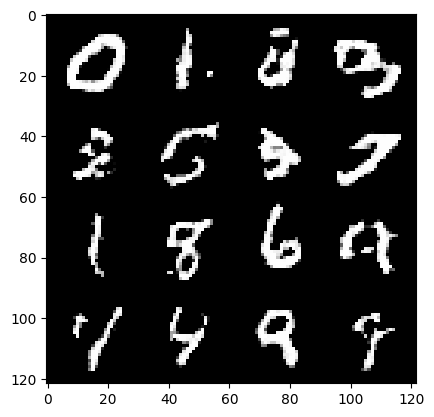

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :  7
Discriminator Loss :  0.5905453110300402
Generator Loss :  1.0486821201818584


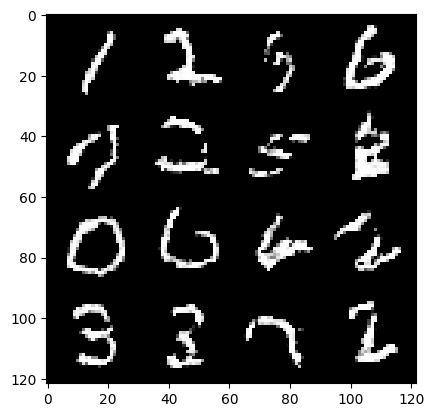

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :  8
Discriminator Loss :  0.5855595437702594
Generator Loss :  1.0609794368367713


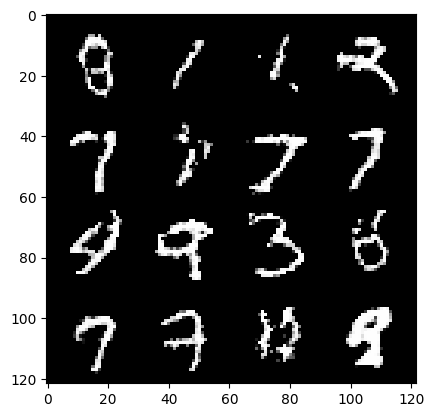

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :  9
Discriminator Loss :  0.5788145330923198
Generator Loss :  1.0922899373304615


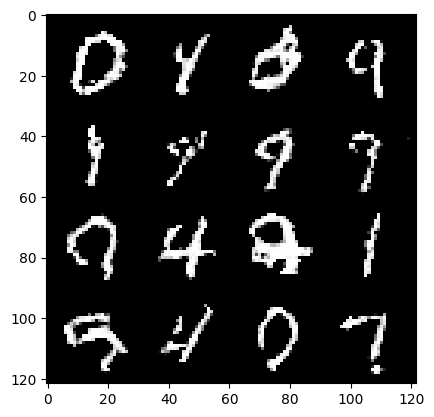

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :  10
Discriminator Loss :  0.564599244198057
Generator Loss :  1.1238805792733295


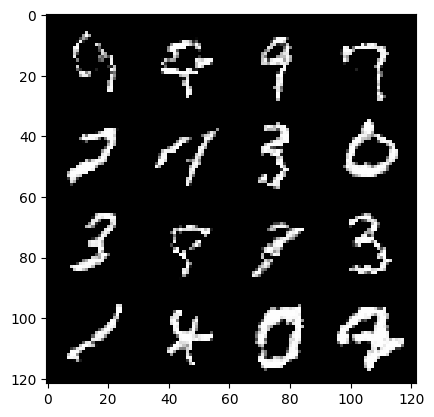

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :  11
Discriminator Loss :  0.553492200717743
Generator Loss :  1.1637678672509915


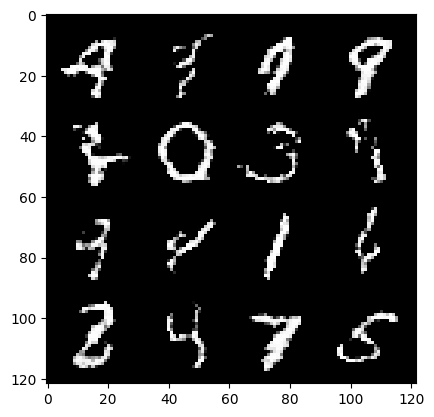

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :  12
Discriminator Loss :  0.5406697968175924
Generator Loss :  1.2045103553007406


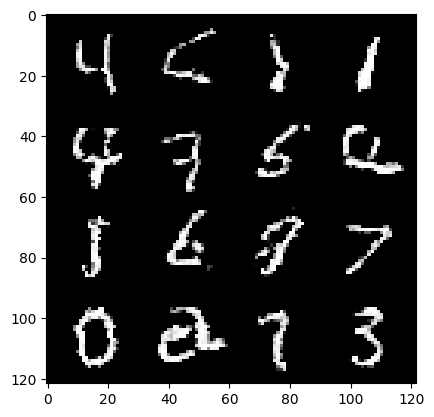

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :  13
Discriminator Loss :  0.5315551967509011
Generator Loss :  1.252284089639497


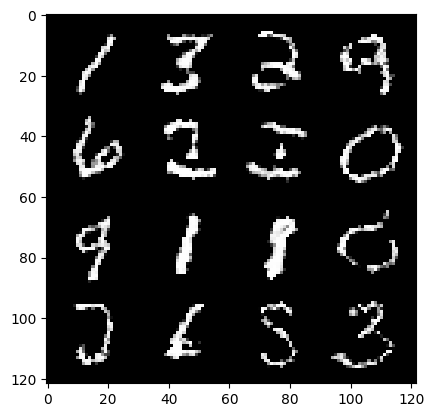

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :  14
Discriminator Loss :  0.5175752412281565
Generator Loss :  1.2906854696619485


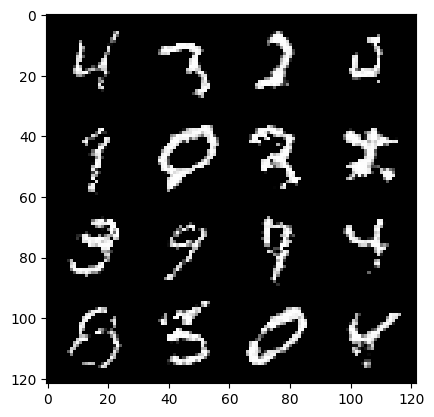

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :  15
Discriminator Loss :  0.5058700899198365
Generator Loss :  1.3395690333360293


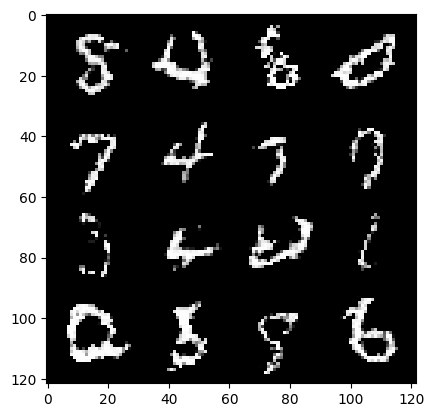

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :  16
Discriminator Loss :  0.5079926174840947
Generator Loss :  1.360108964224614


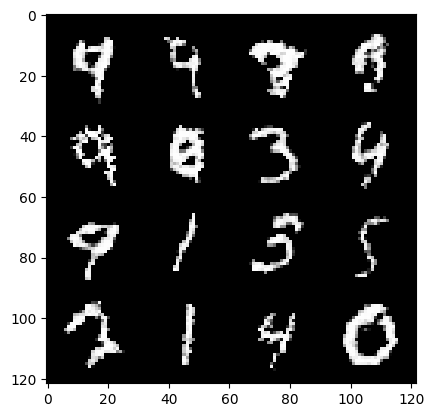

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :  17
Discriminator Loss :  0.5124874440337549
Generator Loss :  1.3725890596029855


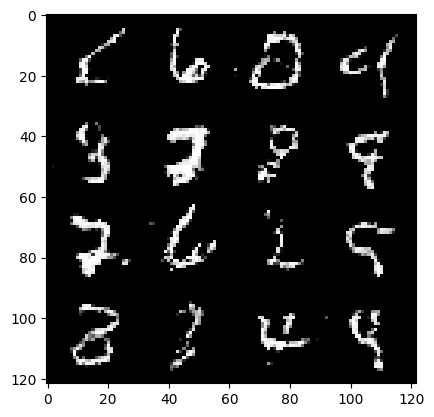

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :  18
Discriminator Loss :  0.5035910424011857
Generator Loss :  1.3750989795493673


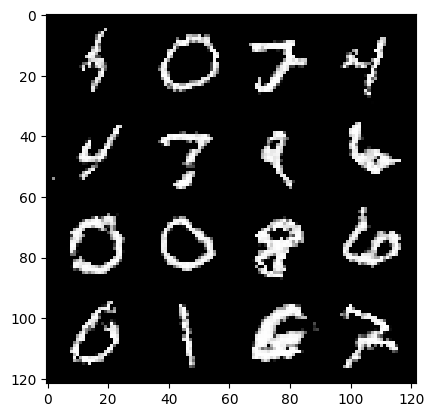

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :  19
Discriminator Loss :  0.5082673785020547
Generator Loss :  1.382723946561183


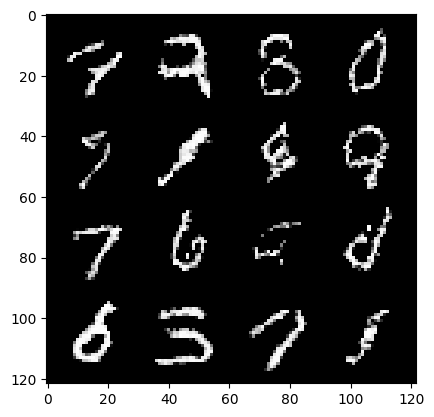

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch :  20
Discriminator Loss :  0.5064919897869452
Generator Loss :  1.3725757448912175


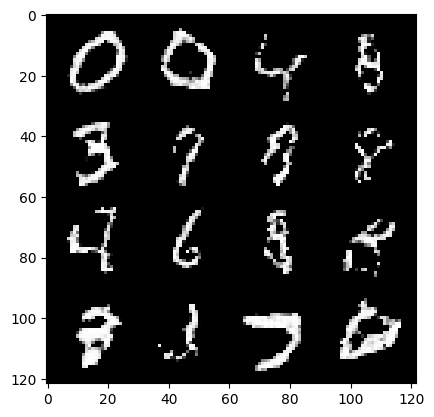

In [44]:
for i in range(epochs):

  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm(trainloader):
    real_img = real_img.to(device)

    # Find loss and update weights for D
    D_opt.zero_grad()

    noise = torch.randn(batch_size, noise_dim, device = device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2
    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()


    # Find loss and update weights for G
    G_opt.zero_grad()

    noise = torch.randn(batch_size, noise_dim, device = device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)
    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()


  avg_d_loss = total_d_loss/len(trainloader)
  avg_g_loss = total_g_loss/len(trainloader)


  print("Epoch : ", i+1)
  print("Discriminator Loss : ", avg_d_loss)
  print("Generator Loss : ", avg_g_loss)

  show_tensor_images(fake_img)


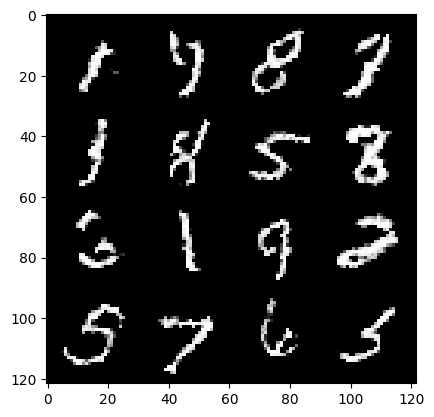

In [45]:
# Now we can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)